In [3]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelBinarizer

from nltk.corpus import stopwords

from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "glove/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

train = pd.read_csv('classifier_data_10.csv')

filtered = train.groupby('owner')['owner'].filter(lambda x: len(x) >= 500)
# f = train[train['owner'].isin(filtered)][:1000]
f = train[train['owner'].isin(filtered)]

train = f
df = f

train.dropna(inplace=True)
train.isnull().sum()
len(f['owner'].unique())

labels = f['owner'].unique()
# y = train['owner'].values
y = LabelBinarizer().fit_transform(df.owner)
comments_train = train['description']
comments_train = list(comments_train)

In [4]:
f['owner'].unique()

array(['pfeldman@chromium.org', 'tkent@chromium.org', 'sky@chromium.org',
       'estade@chromium.org', 'a...@chromium.org', 'sosa@chromium.org',
       'ananta@chromium.org', 'steve...@chromium.org',
       'e...@chromium.org', 'davidjames@chromium.org',
       'dgozman@chromium.org', 'tha...@chromium.org',
       'thestig@chromium.org'], dtype=object)

In [5]:
df.shape

(8862, 3)

In [6]:
raw_text = df['description'].values

In [7]:
import numpy as np
print(np.__version__)

1.19.5


In [8]:
len(raw_text)

8862

In [9]:

def clean_text(text, remove_stopwords = True):
    output = ""
    text = str(text).replace("\n", "")
    text = re.sub(r'[^\w\s]','',text).lower()
    if remove_stopwords:
        text = text.split(" ")
        for word in text:
            if word not in stopwords.words("english"):
                output = output + " " + word
    else:
        output = text
    return str(output.strip())[1:-3].replace("  ", " ")
    
# texts = [] 

# for line in tqdm_notebook(comments_train, total=159571): 
#     texts.append(clean_text(line))

In [10]:
texts = [] 
for line in raw_text: 
    texts.append(clean_text(line))

In [11]:
print('Sample data:', texts[1], y[1])


Sample data: roduct version    chrome beta 1urls applicable browsers testedadd ok fail browsers tested issue   safari 3 ok  firefox 3 irrelevant     ie 7 irrelevantwhat steps reproduce problem1 rightclick web element2 click inspect element3 click dock main windowwhat expected resultto webinspector get docked bottom current tabwhat happens insteadnothingplease provide additional information attach screenshot possi [0 0 0 0 0 0 1 0 0 0 0 0 0]


In [12]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 114590


In [31]:
len(sequences[0])

51

In [33]:
len(texts[0])

403

In [13]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (8862, 200)
Shape of label tensor: (8862, 13)


In [14]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [15]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [ 431  573  547  447  503 1006  567  769  416  401  533  392  505]
validation:  [ 94 138 145 106 110 243 153 177 126  99 139 118 124]


In [27]:
print('Tokenized sentences: \n', data[10])
print('Text: \n', texts[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [  386 13413   163  1289     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0    

In [17]:
embeddings_index = {}
f = open(GLOVE_DIR, encoding="utf8")
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: glove/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [18]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import keras
from keras import backend as K
from keras import activations, initializers, regularizers, constraints, metrics
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import (Dense, Dropout, Activation, Flatten, Reshape, Layer,
                          BatchNormalization, LocallyConnected2D,
                          ZeroPadding2D, Conv2D, MaxPooling2D, Conv2DTranspose,
                          GaussianNoise, UpSampling2D, Input)
# from keras.utils import conv_utils, multi_gpu_model
# from keras.layers import Lambda
# from keras.engine import Layer, InputSpec
# from keras.legacy import interfaces

In [19]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(13, activation="sigmoid")(x)

In [20]:
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 100)          11459100  
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           38640     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

In [23]:
x_val.shape

(1772, 200)

In [24]:
y_val.shape

(1772, 13)

In [25]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 2, batch_size=32, validation_data=(x_val, y_val))

Training progress:
Epoch 1/2
222/222 [==============================] - 16s 64ms/step - loss: 0.3182 - accuracy: 0.1106 - val_loss: 0.2669 - val_accuracy: 0.1309
Epoch 2/2
222/222 [==============================] - 16s 74ms/step - loss: 0.2694 - accuracy: 0.1465 - val_loss: 0.2629 - val_accuracy: 0.1563


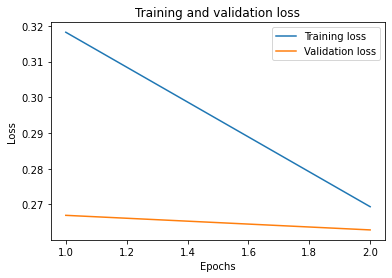

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();